In [ ]:
"""
Potential Other features
 - some measure of base_fee over the day, which is a model for the demand over the day.
   need to aggregate epoch level into day level.  --> can just use different quantiles as features
   This would then require us to generate those features to create new forecasts, so not ideal.
   Forecasting total_gas used / day is a proxy for demand as well.
"""

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os

import numpy as np
import pandas as pd
import sqlalchemy as sqa

from jax.random import PRNGKey
import jax.numpy as jnp
from jax import random

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, log_likelihood

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import scenario_generator.utils as u
import cel_utils.disk_utils as du

import gas_models

In [3]:
save_dir = os.path.join(os.environ['HOME'], 'Documents', 'direct_filp_v3')
offline_dir = os.path.join(save_dir, 'offline')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_dir, exist_ok=True)

In [4]:
training_start_date = date(2022, 12, 1)  # this corresponds to the date that FIP45 was passed, which changed how much gas PSD messages took
training_end_date = date.today()-timedelta(days=3)

full_df = gas_models.get_training_data(training_start_date, training_end_date)

# train/test split
n_samp = len(full_df)
n_train = int(n_samp * 0.7)

train_df = full_df.iloc[0:n_train]
test_df = full_df.iloc[n_train:]

num_mc = 500

In [5]:
full_df.head()

,stat_date,total_gas_used,provecommit_sector_gas_used,precommit_sector_gas_used,provecommit_aggregate_gas_used,precommit_sector_batch_gas_used,publish_storage_deals_gas_used,submit_windowed_post_gas_used,date,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,total_raw_power_eib,total_qa_power_eib,fpr,day_onboarded_deal_power,network_qa_rb_ratio,precommitx_sector_gas_used,provecommitx_sector_gas_used
0,2022-12-01T00:00:00Z,47669602126167,6946921288931,5473800854866,4173581349773,1218855229834,13390461427535,11093536613536,2022-12-01,4.900513,28.193371,15.287992,18.637933,0.826182,2.588095,1.219122,6692656084700,11120502638704
1,2022-12-02T00:00:00Z,45607885065483,9307313574487,5489882794848,1976727065402,877822198281,11838746143109,10828102503580,2022-12-02,5.463226,25.302952,15.391210,18.786623,0.784087,2.204414,1.220607,6367704993129,11284040639889
2,2022-12-03T00:00:00Z,44431816043360,11293222469159,8832805859531,13333315382,119246934388,11203538398130,8766646324191,2022-12-03,5.796570,22.516809,15.494154,18.916621,0.742567,1.857804,1.220888,8952052793919,11306555784541
3,2022-12-04T00:00:00Z,41150077997254,11346935334084,9689904658983,2116221197,74609249,10762030982806,7149476871990,2022-12-04,5.967133,23.355089,15.508494,18.957937,0.744504,1.931995,1.222423,9689979268232,11349051555281
4,2022-12-05T00:00:00Z,42849385237355,10859472903098,9986979799607,0,0,10074386059308,6842666672362,2022-12-05,5.757080,21.780867,15.504893,18.974549,0.735682,1.780421,1.223778,9986979799607,10859472903098


<IPython.core.display.Javascript object>


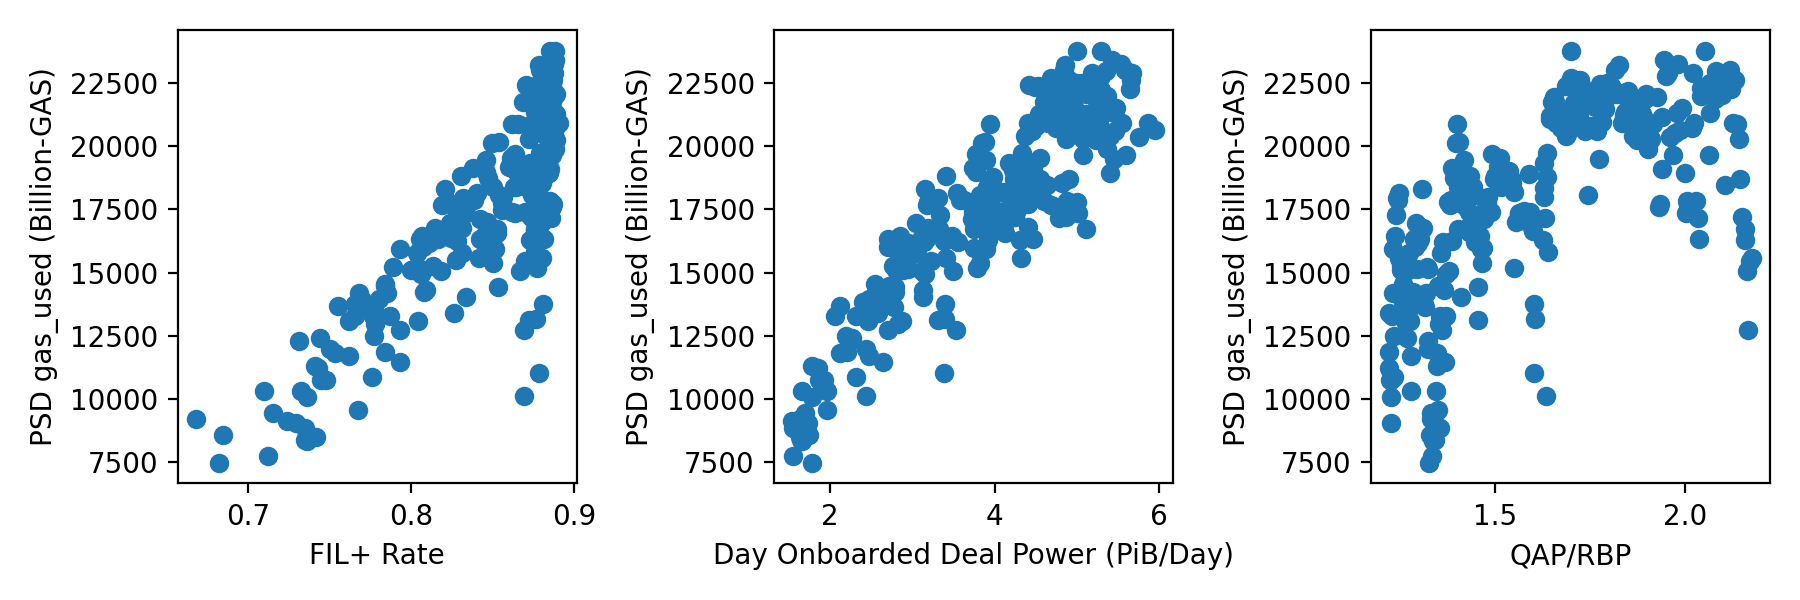

In [6]:
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.scatter(full_df['fpr'], full_df['publish_storage_deals_gas_used']*1e-9)
plt.xlabel('FIL+ Rate')
plt.ylabel('PSD gas_used (Billion-GAS)')

plt.subplot(1,3,2)
plt.scatter(full_df['day_onboarded_deal_power'], full_df['publish_storage_deals_gas_used']*1e-9)
plt.xlabel('Day Onboarded Deal Power (PiB/Day)')
plt.ylabel('PSD gas_used (Billion-GAS)')

plt.subplot(1,3,3)
plt.scatter(full_df['network_qa_rb_ratio'], full_df['publish_storage_deals_gas_used']*1e-9)
plt.xlabel('QAP/RBP')
plt.ylabel('PSD gas_used (Billion-GAS)')

plt.tight_layout()

<IPython.core.display.Javascript object>


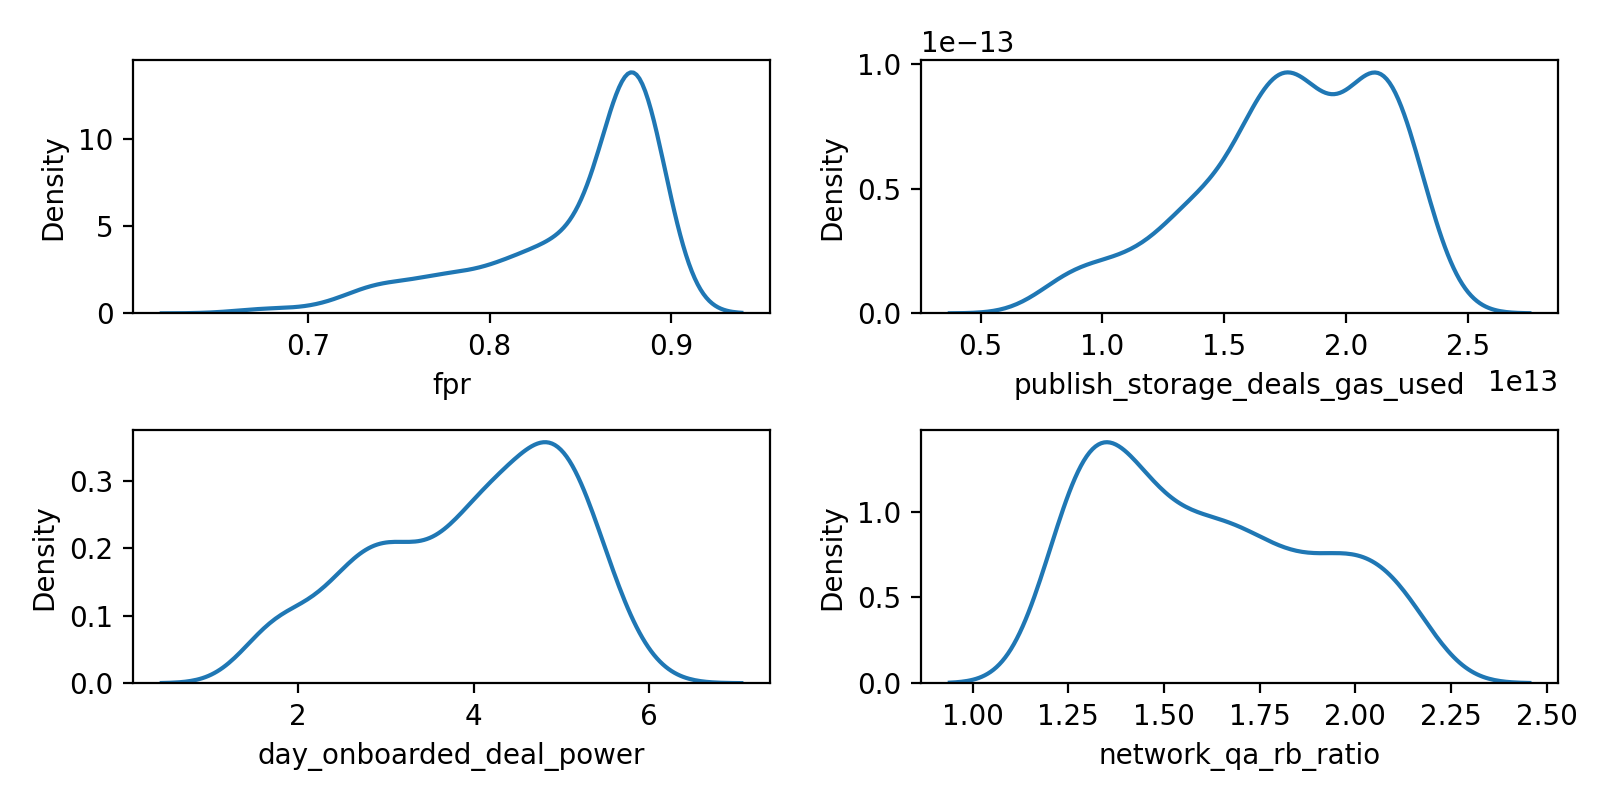

In [7]:
plt.figure(figsize=(8,4))

plt.subplot(2,2,1)
sns.kdeplot(full_df['fpr'])

plt.subplot(2,2,2)
sns.kdeplot(full_df['publish_storage_deals_gas_used'])

plt.subplot(2,2,3)
sns.kdeplot(full_df['day_onboarded_deal_power'])

plt.subplot(2,2,4)
sns.kdeplot(full_df['network_qa_rb_ratio'])

plt.tight_layout()

In [58]:
# Train PSD Model w/ GasX
psd_gasxmodel = gas_models.GasxGasModel('psd', log_after_scaler=True)
r = psd_gasxmodel.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.047025
Acceptance rate of Metropolis-Hastings is 0.436425
Acceptance rate of Metropolis-Hastings is 0.353625

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.349925
Normal GAS X(1,0,1)                                                                                       
======================================================= ==================================================
Dependent Variable: publish_storage_deals_gas_used      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: 287.1443              
End Date: 189                                           AIC: -562.2885211003656                           
Number of observations: 189                             BIC: -542.8380390100078                           
Latent Variable                          Median             Mean               95% Credibility Interval 
=================

In [71]:
# Train PSD Model w/ GasX
psd_gasxmodel_nolog = gas_models.GasxGasModel('psd', log_after_scaler=False)
r = psd_gasxmodel_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.122075
Acceptance rate of Metropolis-Hastings is 0.19545
Acceptance rate of Metropolis-Hastings is 0.287675

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2915
Normal GAS X(1,0,1)                                                                                       
======================================================= ==================================================
Dependent Variable: publish_storage_deals_gas_used      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -81.9532              
End Date: 189                                           AIC: 175.90638538675643                           
Number of observations: 189                             BIC: 195.3568674771143                            
Latent Variable                          Median             Mean               95% Credibility Interval 
====================

In [59]:
# Train PSD Model w/ ARIMAX
psd_arimax_model = gas_models.ArimaxGasModel('psd', log_after_scaler=True)
r = psd_arimax_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.045275
Acceptance rate of Metropolis-Hastings is 0.433675
Acceptance rate of Metropolis-Hastings is 0.3455

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.3451375
Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: publish_storage_deals_gas_used      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: 289.5258              
End Date: 189                                           AIC: -567.0515150707804                           
Number of observations: 189                             BIC: -547.6010329804226                           
Latent Variable                          Median             Mean               95% Credibility Interval 
==================

In [62]:
# Train PSD Model w/ ARIMAX
psd_arimax_model_nolog = gas_models.ArimaxGasModel('psd', log_after_scaler=False)
r = psd_arimax_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.110125
Acceptance rate of Metropolis-Hastings is 0.1858
Acceptance rate of Metropolis-Hastings is 0.27735

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2789125
Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: publish_storage_deals_gas_used      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -75.4625              
End Date: 189                                           AIC: 162.9249008312251                            
Number of observations: 189                             BIC: 182.37538292158297                           
Latent Variable                          Median             Mean               95% Credibility Interval 
===================

In [72]:
# using the forecast convenience function takes care of normalizing, unnormalizing, etc
y_pred_gasxpsd = psd_gasxmodel.forecast(test_df, num_mc)  
y_pred_gasxpsd_nolog = psd_gasxmodel_nolog.forecast(test_df, num_mc)  
y_pred_arimaxpsd = psd_arimax_model.forecast(test_df, num_mc) 
y_pred_arimaxpsd_nolog = psd_arimax_model_nolog.forecast(test_df, num_mc) 

<IPython.core.display.Javascript object>


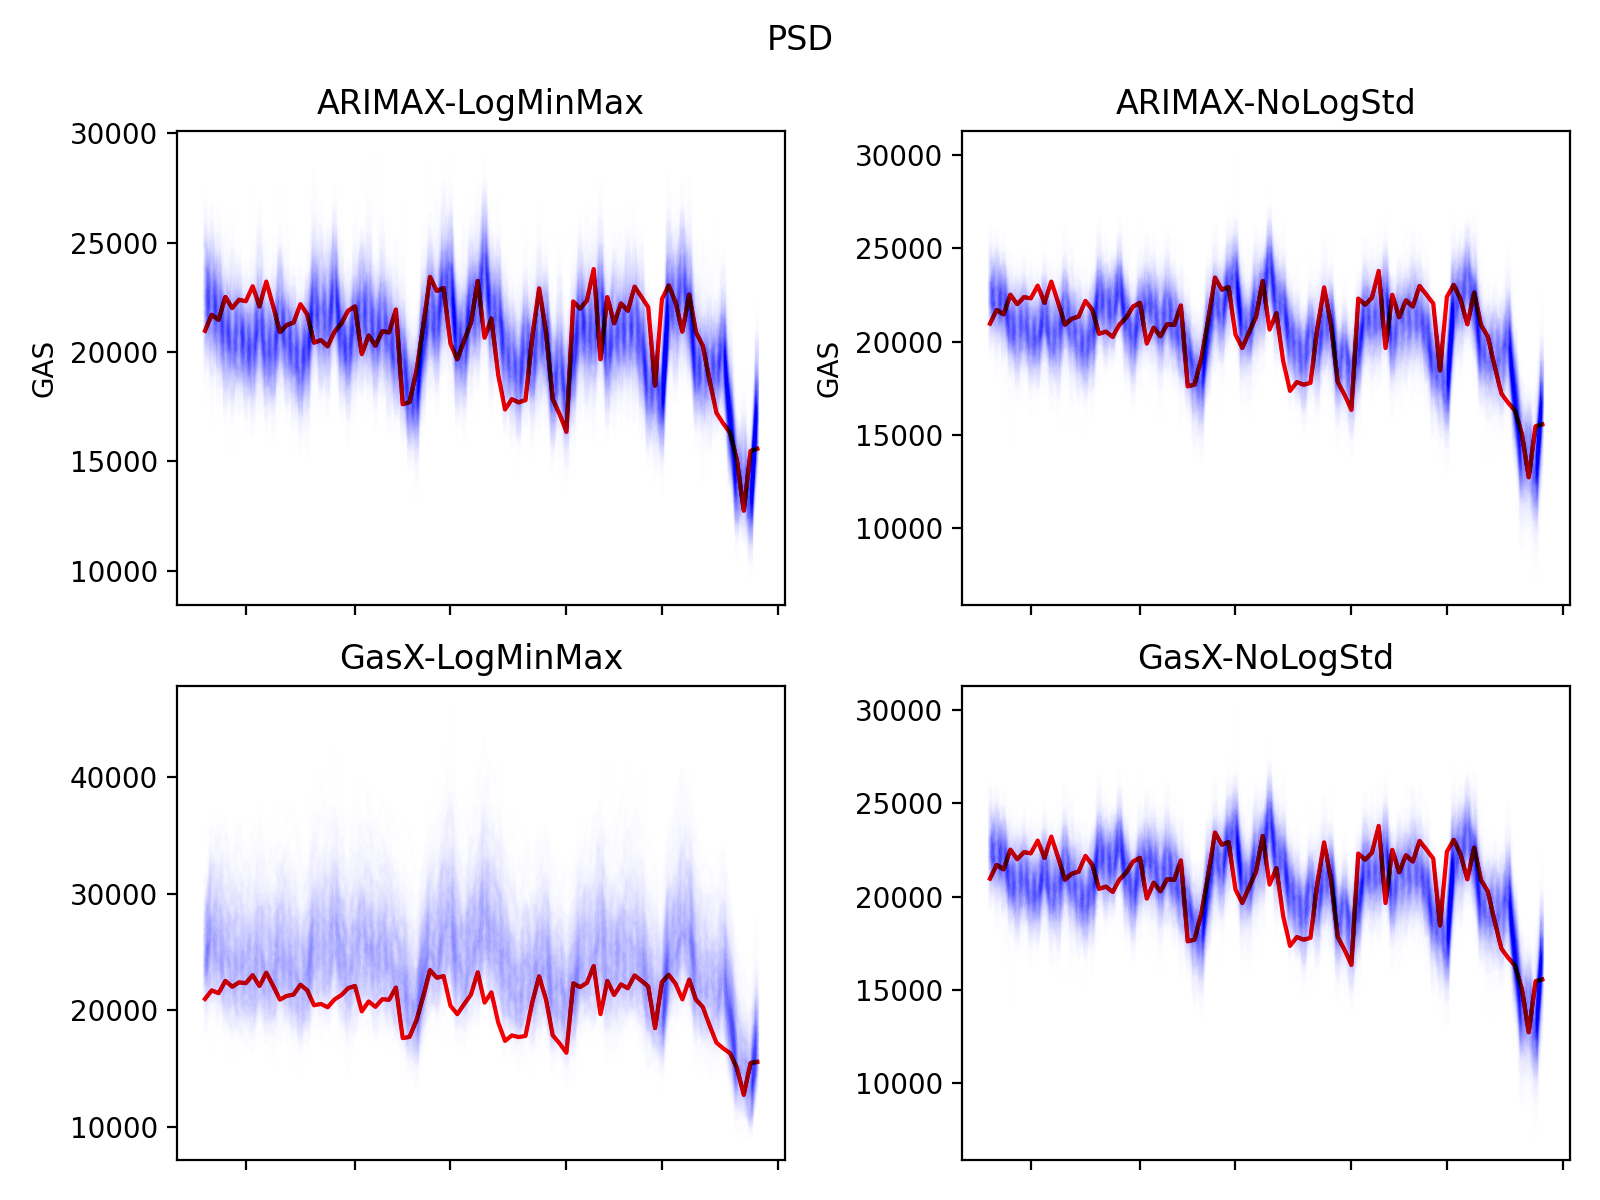

In [74]:
scale=1e-9
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,6))

axx = ax[0,0]
axx.plot(test_df['date'], test_df['publish_storage_deals_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], y_pred_arimaxpsd[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-LogMinMax')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[0,1]
axx.plot(test_df['date'], test_df['publish_storage_deals_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], y_pred_arimaxpsd_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-NoLogStd')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,0]
axx.plot(test_df['date'], test_df['publish_storage_deals_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], y_pred_gasxpsd[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-LogMinMax')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,1]
axx.plot(test_df['date'], test_df['publish_storage_deals_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], y_pred_arimaxpsd_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-NoLogStd')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

plt.suptitle('PSD')
plt.tight_layout()

In [65]:
# Train PrecommitX Model
precommitx_armiax_model = gas_models.ArimaxGasModel('precommitx', log_after_scaler=True)
r = precommitx_armiax_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 2.5e-05
Acceptance rate of Metropolis-Hastings is 0.0847
Acceptance rate of Metropolis-Hastings is 0.240525

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2029375
Acceptance rate of Metropolis-Hastings is 0.280825
Normal ARIMAX(1,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: precommitx_sector_gas_used          Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 255.7466              
End Date: 189                                           AIC: -493.4932692460904                           
Number of observations: 188                             BIC: -464.36529158062086                          
Latent Variable                          Median             Mean         

In [67]:
precommitx_armiax_model_nolog = gas_models.ArimaxGasModel('precommitx', log_after_scaler=False)
r = precommitx_armiax_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.002075
Acceptance rate of Metropolis-Hastings is 0.16795
Acceptance rate of Metropolis-Hastings is 0.223425
Acceptance rate of Metropolis-Hastings is 0.303225

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2683375
Normal ARIMAX(1,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: precommitx_sector_gas_used          Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: -72.2479              
End Date: 189                                           AIC: 162.49580853385257                           
Number of observations: 188                             BIC: 191.62378619932213                           
Latent Variable                          Median             Mean       

In [81]:
# Train PrecommitX Model
precommitx_gasx_model = gas_models.GasxGasModel('precommitx', log_after_scaler=True)
r = precommitx_gasx_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.002
Acceptance rate of Metropolis-Hastings is 0.163025
Acceptance rate of Metropolis-Hastings is 0.22105
Acceptance rate of Metropolis-Hastings is 0.340375

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2990375
Normal GAS X(1,0,2)                                                                                       
======================================================= ==================================================
Dependent Variable: precommitx_sector_gas_used          Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 250.472               
End Date: 189                                           AIC: -482.9439189745326                           
Number of observations: 188                             BIC: -453.8159413090631                           
Latent Variable                          Median             Mean          

In [82]:
precommitx_gasx_model_nolog = gas_models.GasxGasModel('precommitx', log_after_scaler=False)
r = precommitx_gasx_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0027
Acceptance rate of Metropolis-Hastings is 0.161075
Acceptance rate of Metropolis-Hastings is 0.215625
Acceptance rate of Metropolis-Hastings is 0.291775

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2730625
Normal GAS X(1,0,2)                                                                                       
======================================================= ==================================================
Dependent Variable: precommitx_sector_gas_used          Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: -79.7087              
End Date: 189                                           AIC: 177.41749525028294                           
Number of observations: 188                             BIC: 206.5454729157525                            
Latent Variable                          Median             Mean        

In [84]:
ypred_armiax_precommitx = precommitx_armiax_model.forecast(test_df, num_mc)
ypred_armiax_precommitx_nolog = precommitx_armiax_model_nolog.forecast(test_df, num_mc)
# ypred_gasx_precommitx = precommitx_gasx_model.forecast(test_df, num_mc)
# ypred_gasx_precommitx_nolog = precommitx_gasx_model_nolog.forecast(test_df, num_mc)

<IPython.core.display.Javascript object>


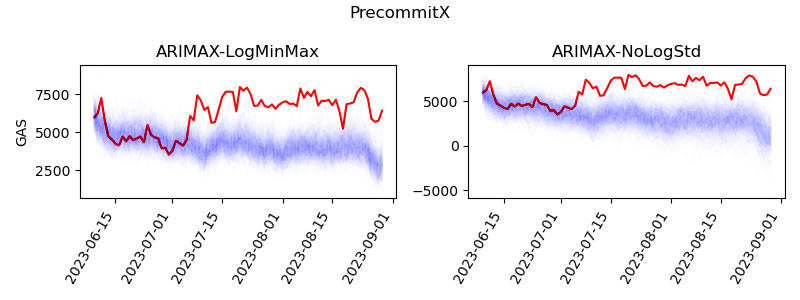

In [86]:
# NOTE: GasX model fails here for some reason?

scale=1e-9
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(8,3))

# axx = ax[0,0]
axx = ax[0]
axx.plot(test_df['date'], test_df['precommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_armiax_precommitx[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-LogMinMax')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

# axx = ax[0,1]
axx = ax[1]
axx.plot(test_df['date'], test_df['precommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_armiax_precommitx_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-NoLogStd')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

# axx = ax[1,1]
# axx.plot(test_df['date'], test_df['precommitx_sector_gas_used']*scale, color='r', label='True')
# for ii in range(num_mc):
#     l = 'Forecast' if ii == 0 else None
#     axx.plot(test_df['date'], ypred_gasx_precommitx[ii,:]*scale, color='b', alpha=0.005, label=l)
# axx.set_title('GasX-LogMinMax')
# axx.set_ylabel('GAS')
# axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

# axx = ax[1,0]
# axx.plot(test_df['date'], test_df['precommitx_sector_gas_used']*scale, color='r', label='True')
# for ii in range(num_mc):
#     l = 'Forecast' if ii == 0 else None
#     axx.plot(test_df['date'], ypred_gasx_precommitx_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
# axx.set_title('GasX-NoLogStd')
# axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

plt.suptitle('PrecommitX')
plt.tight_layout()

In [75]:
provecommitx_arimax_model = gas_models.ArimaxGasModel('provecommitx', log_after_scaler=True)
r = provecommitx_arimax_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.046325
Acceptance rate of Metropolis-Hastings is 0.275775

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.3103
Normal ARIMAX(2,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: provecommitx_sector_gas_used        Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 298.362               
End Date: 189                                           AIC: -580.7239570821746                           
Number of observations: 188                             BIC: -554.832421379535                            
Latent Variable                          Median             Mean               95% Credibility Interval 
========================

In [76]:
provecommitx_arimax_model_nolog = gas_models.ArimaxGasModel('provecommitx', log_after_scaler=False)
r = provecommitx_arimax_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0024
Acceptance rate of Metropolis-Hastings is 0.155725
Acceptance rate of Metropolis-Hastings is 0.2051
Acceptance rate of Metropolis-Hastings is 0.25925

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.255025
Normal ARIMAX(1,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: provecommitx_sector_gas_used        Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -139.6837             
End Date: 189                                           AIC: 293.3673610998345                            
Number of observations: 189                             BIC: 316.059590205252                             
Latent Variable                          Median             Mean            

In [77]:
provecommitx_gasx_model = gas_models.GasxGasModel('provecommitx', log_after_scaler=True)
r = provecommitx_gasx_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.000675
Acceptance rate of Metropolis-Hastings is 0.091125
Acceptance rate of Metropolis-Hastings is 0.27345

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.26275
Normal GAS X(2,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: provecommitx_sector_gas_used        Method: Metropolis Hastings                       
Start Date: 2                                           Unnormalized Log Posterior: 266.8978              
End Date: 189                                           AIC: -517.7956897808947                           
Number of observations: 188                             BIC: -491.9041540782551                           
Latent Variable                          Median             Mean               95% Credibility Interval 
===================

In [78]:
provecommitx_gasx_model_nolog = gas_models.GasxGasModel('provecommitx', log_after_scaler=False)
r = provecommitx_gasx_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.0033
Acceptance rate of Metropolis-Hastings is 0.206475
Acceptance rate of Metropolis-Hastings is 0.267675

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2784375
Normal GAS X(1,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: provecommitx_sector_gas_used        Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -177.7285             
End Date: 189                                           AIC: 369.45696330401876                           
Number of observations: 189                             BIC: 392.14919240943624                           
Latent Variable                          Median             Mean               95% Credibility Interval 
==================

In [79]:
ypred_armiax_provecommitx = provecommitx_arimax_model.forecast(test_df, num_mc)
ypred_gasx_provecommitx = provecommitx_gasx_model.forecast(test_df, num_mc)
ypred_armiax_provecommitx_nolog = provecommitx_arimax_model_nolog.forecast(test_df, num_mc)
ypred_gasx_provecommitx_nolog = provecommitx_gasx_model_nolog.forecast(test_df, num_mc)

<IPython.core.display.Javascript object>


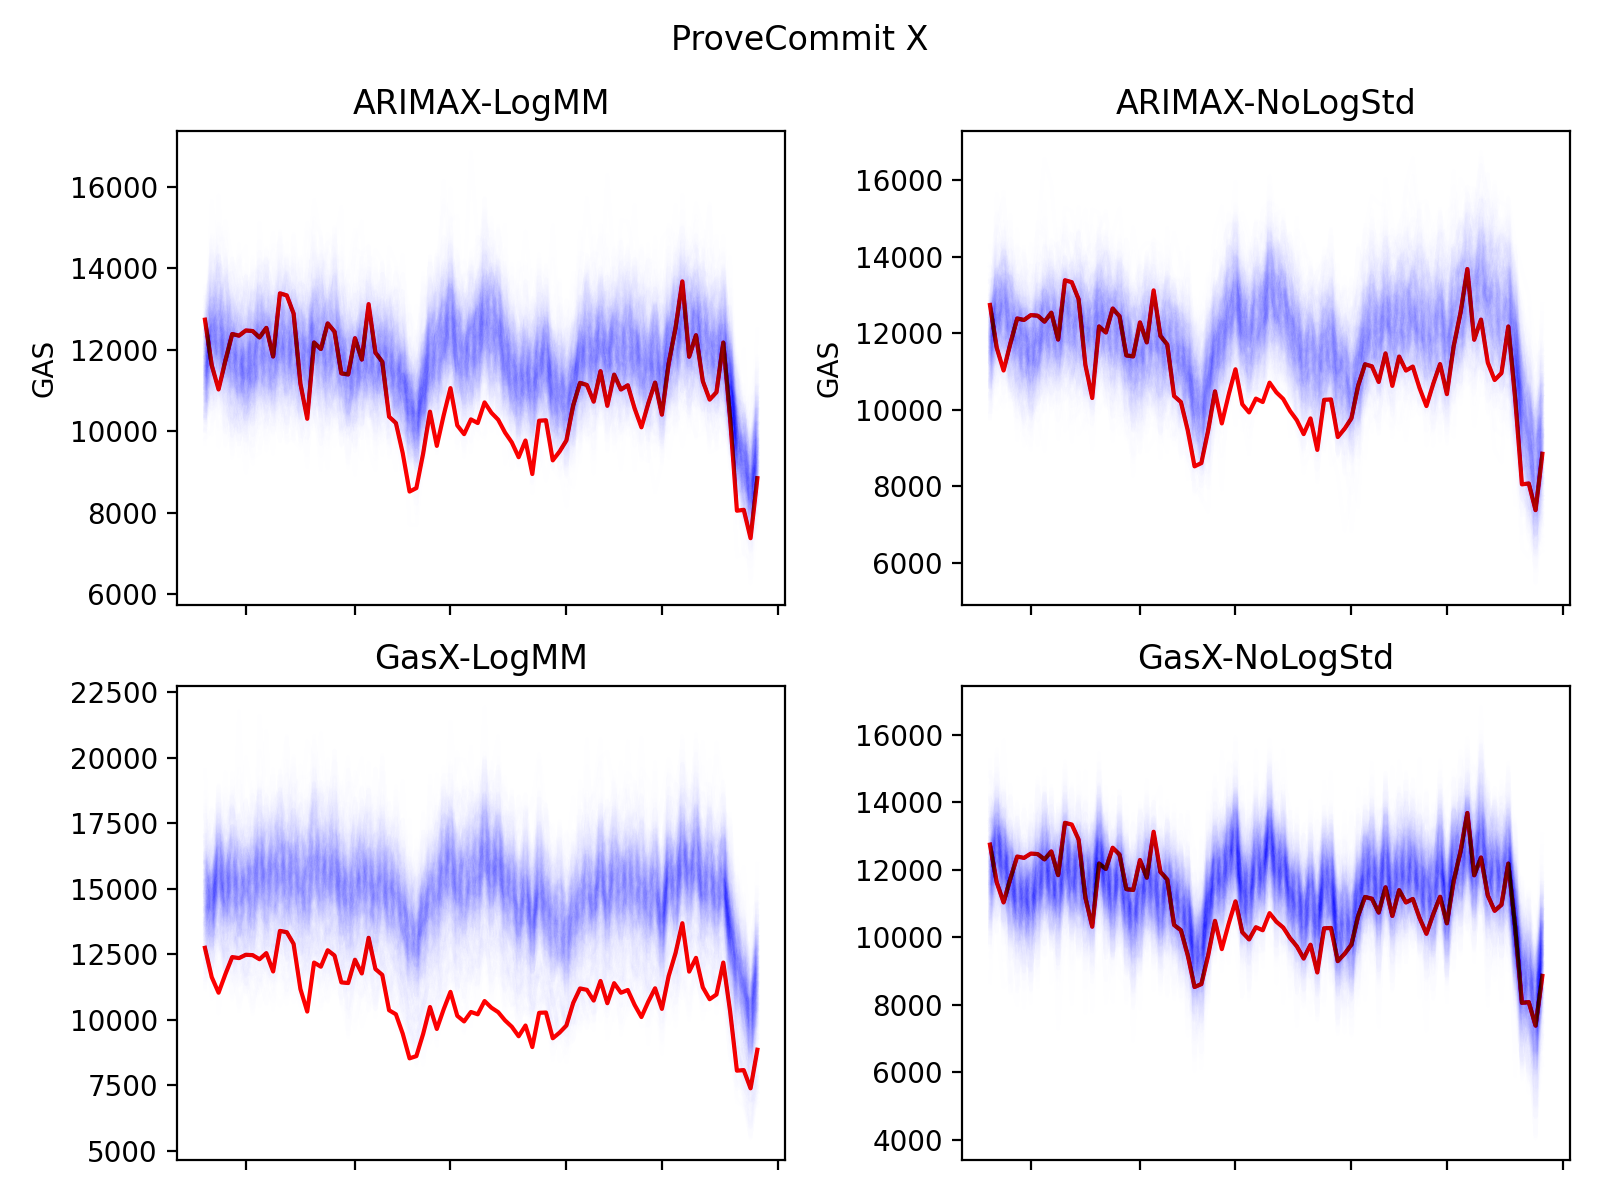

In [80]:
scale=1e-9
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,6))

axx = ax[0,0]
axx.plot(test_df['date'], test_df['provecommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_armiax_provecommitx[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-LogMM')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[0,1]
axx.plot(test_df['date'], test_df['provecommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_armiax_provecommitx_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-NoLogStd')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,0]
axx.plot(test_df['date'], test_df['provecommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_gasx_provecommitx[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-LogMM')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,1]
axx.plot(test_df['date'], test_df['provecommitx_sector_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_gasx_provecommitx_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-NoLogStd')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

plt.suptitle('ProveCommit X')
plt.tight_layout()

In [87]:
totalgas_arimax_model = gas_models.ArimaxGasModel('total', log_after_scaler=True)
r = totalgas_arimax_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.000375
Acceptance rate of Metropolis-Hastings is 0.06375
Acceptance rate of Metropolis-Hastings is 0.184075
Acceptance rate of Metropolis-Hastings is 0.236425

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.25095
Normal ARIMAX(1,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: total_gas_used                      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: 213.7563              
End Date: 189                                           AIC: -413.51251901960956                          
Number of observations: 189                             BIC: -390.8202899141921                           
Latent Variable                          Median             Mean         

In [88]:
totalgas_arimax_model_nolog = gas_models.ArimaxGasModel('total', log_after_scaler=False)
r = totalgas_arimax_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.003875
Acceptance rate of Metropolis-Hastings is 0.2066
Acceptance rate of Metropolis-Hastings is 0.26155

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2645875
Normal ARIMAX(3,0,0)                                                                                      
======================================================= ==================================================
Dependent Variable: total_gas_used                      Method: Metropolis Hastings                       
Start Date: 3                                           Unnormalized Log Posterior: -164.3423             
End Date: 189                                           AIC: 346.68457725455266                           
Number of observations: 187                             BIC: 375.76455480624395                           
Latent Variable                          Median             Mean               95% Credibility Interval 
===================

In [89]:
totalgas_gasx_model = gas_models.GasxGasModel('total', log_after_scaler=True)
r = totalgas_gasx_model.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.001175
Acceptance rate of Metropolis-Hastings is 0.10215
Acceptance rate of Metropolis-Hastings is 0.1365
Acceptance rate of Metropolis-Hastings is 0.18615
Acceptance rate of Metropolis-Hastings is 0.224125
Acceptance rate of Metropolis-Hastings is 0.272475

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.29105
Normal GAS X(1,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: total_gas_used                      Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: 177.5585              
End Date: 189                                           AIC: -341.11690273665846                          
Number of observations: 189                             BIC: -318.424673631241   

In [90]:
totalgas_gasx_model_nolog = gas_models.GasxGasModel('total', log_after_scaler=False)
r = totalgas_gasx_model_nolog.train_model(train_df)
r.summary()

Acceptance rate of Metropolis-Hastings is 0.003825
Acceptance rate of Metropolis-Hastings is 0.243775

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2657375
Normal GAS X(3,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: total_gas_used                      Method: Metropolis Hastings                       
Start Date: 3                                           Unnormalized Log Posterior: -208.3722             
End Date: 189                                           AIC: 434.7443342592346                            
Number of observations: 187                             BIC: 463.8243118109259                            
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== =======

In [91]:
ypred_armiax_total = totalgas_arimax_model.forecast(test_df, num_mc)
ypred_gasx_total = totalgas_gasx_model.forecast(test_df, num_mc)
ypred_armiax_total_nolog = totalgas_arimax_model_nolog.forecast(test_df, num_mc)
ypred_gasx_total_nolog = totalgas_gasx_model_nolog.forecast(test_df, num_mc)

<IPython.core.display.Javascript object>


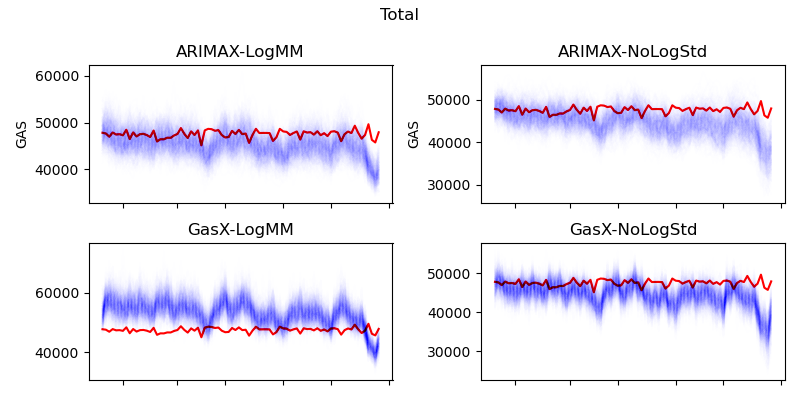

In [92]:
scale=1e-9
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,4))

axx = ax[0,0]
axx.plot(test_df['date'], test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_armiax_total[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-LogMM')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[0,1]
axx.plot(test_df['date'], test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_armiax_total_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('ARIMAX-NoLogStd')
axx.set_ylabel('GAS')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,0]
axx.plot(test_df['date'], test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_gasx_total[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-LogMM')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

axx = ax[1,1]
axx.plot(test_df['date'], test_df['total_gas_used']*scale, color='r', label='True')
for ii in range(num_mc):
    l = 'Forecast' if ii == 0 else None
    axx.plot(test_df['date'], ypred_gasx_total_nolog[ii,:]*scale, color='b', alpha=0.005, label=l)
axx.set_title('GasX-NoLogStd')
axx.set_xticks(axx.get_xticks(), axx.get_xticklabels(), rotation=60, ha='right')

plt.suptitle('Total Gas Usage')
plt.tight_layout()